   # MIE 1622 Assignment 1

### Import all Libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import cplex

### Buy and Hold Strategy

In [2]:
# BUY AND HOLD
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    
    x_optimal = x_init
    
    cash_optimal = cash_init
    
    return x_optimal, cash_optimal

### Equally Weighted Strategy

In [3]:
# EQUALLY WEIGHTED
def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    
    portfolio_value = np.dot(cur_prices,x_init) + cash_init

    money_allocation = np.ones((20)) * portfolio_value / 20 # equally allocate money for each asset

    x_optimal = np.floor(money_allocation / cur_prices)

    tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005

    cash_optimal = portfolio_value - np.dot(cur_prices,x_optimal) - tran_cost
        
    return x_optimal, cash_optimal

### Minimum Variance Strategy

In [4]:
# MIN VARIANCE
def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    
    portfolio_value = np.dot(cur_prices,x_init) + cash_init
    
    n = 20
    cpx = cplex.Cplex() # create cplex object
    cpx.objective.set_sense(cpx.objective.sense.minimize) #minimize objective
    c = np.zeros((20)) # no linear objective
    lb = np.zeros((20))
    ub = np.ones((20))
    
    A = []
    for i in range(n):
        A.append([[0,1],[1,0]]) # one column of ones times corresponding weights
    var_names = ['w_%s'% i for i in range(1,n+1)] #w1,w2,w3.....
    cpx.linear_constraints.add(rhs=[1.0,0],senses='EG') # sum of all weights equal to one
    cpx.variables.add(obj=c,lb=lb,ub=ub,columns=A,names=var_names)

    qmat = [[list(range(n)),list(2*Q[k,:])] for k in range(n)] # sparse matrix representation of Q
    cpx.objective.set_quadratic(qmat) #quadratic objective
    cpx.parameters.threads.set(6) #Set concurrent solution algorithm
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None) #disable results output
    cpx.solve()
    w_minVar = np.array(cpx.solution.get_values()) #results of weight matrix
    
    money_allocation = w_minVar * portfolio_value   #allocate money to each asset by weightings
    x_optimal = np.floor(money_allocation / cur_prices)  #get integer shares
    
    tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005
    cash_optimal = portfolio_value - np.dot(cur_prices,x_optimal) - tran_cost

    return x_optimal, cash_optimal

### Maximum Sharpe Ratio Strategy

In [5]:
# MAX SHARPE RATIO
def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):

    portfolio_value = cur_prices.dot(x_init) + cash_init

    n = 21
    r_rf = 0.025
    daily_rf = 0.025 / 252

    Q1 = np.append(Q,np.zeros((20,1)),axis=1)
    new_row = np.zeros((21))
    Q2 = np.vstack([Q1,new_row]) #add new column and new row for risk-free asset

    diff = mu-daily_rf * np.ones(20) # for convenience

    A = []
    for k in range(n-1):
        A.append([[0,1],[diff[k],1.0]])
    A.append([[0,1],[0,-1.0]]) # diff.dot(y)==1

    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    c = [0]*n
    lb = [0]*n
    ub = [np.inf]*n

    var_names = ['y_%s'% i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1.0,0],senses='EE')
    cpx.variables.add(obj=c,lb=lb,ub=ub,columns=A,names=var_names)

    qmat = [[list(range(n)),list(2*Q2[k,:])] for k in range(n)]

    cpx.objective.set_quadratic(qmat)
    cpx.parameters.threads.set(6)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()

    result = np.array(cpx.solution.get_values())
    w_maxSharp = result[0:20]/result[20]

    money_allocation = w_maxSharp * portfolio_value   #allocate money to each asset by weightings
    x_optimal = np.floor(money_allocation / cur_prices)  #get integer shares

    tran_cost = sum(cur_prices * abs(x_optimal-x_init) * 0.005)
    cash_optimal = portfolio_value - np.dot(cur_prices,x_optimal) - tran_cost
    
    return x_optimal, cash_optimal

### Buy and Hold with Equal Weights Strategy

In [6]:
def strat_buy_and_hold_equally(x_init, cash_init, mu, Q, cur_prices):
    
    x_init = np.array(x_init)
    
    portfolio_value = np.dot(cur_prices,x_init) + cash_init
    
    # equally allocated shares of each asset at the begining 
    x_optimal = [1069,3255,1504,95,2736,996,759,1064,457,308,1476,1810,2793,1375,18726,2431,2483,162,1291,1235]

    tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005

    cash_optimal = portfolio_value - np.dot(cur_prices,x_optimal) - tran_cost
        
    return np.array(x_optimal), cash_optimal

### Output Portfolio Values

In [7]:
# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()# prices for each asset
dates = np.array(df['Date'])

# Find the number of trading days in Nov-Dec 2014 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2014)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2014, start from 1/2/2015
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500, 0, 0, 0, 0, 0, 0, 1001, 0, 0, 0])

# Initial value of the portfolio, almost one million
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights, w=v*x/V
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year (2015,2016) 12
N = len(df.columns)-1#20
N_days = len(dates)#504 trading days

# Annual risk-free rate for years 2015-2016 is 2.5%
r_rf = 0.025

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_buy_and_hold_equally']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Minimum Variance Portfolio', 'Max Sharpe Ratio Portfolio', 'Buy and Hold Equally']
#N_strat = 1  
N_strat = len(strategy_functions)  # 5
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_buy_and_hold_equally]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)#4,12
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 15:
        cur_year  = 15 + math.floor(period/7)
    else:
        cur_year  = 2015 + math.floor(period/7)#progress to 2016
    
    
    cur_month = 2*((period-1)%6) + 1#1357911 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
    # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]

    # Execute portfolio selection strategies
    for strategy  in range(4):

      # Get current portfolio positions
        if period == 1:
            curr_positions = init_positions
            curr_cash = 0
            portf_value[strategy] = np.zeros((N_days, 1))
        else:
            curr_positions = x[strategy, period-2]
            curr_cash = cash[strategy, period-2]
        
        # Compute strategy
        x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)
       
        # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
        # Check that cash account is >= 0
        # Check that we can buy new portfolio subject to transaction costs

        ###################### Insert your code here ############################
        
        if cash[strategy, period-1] < 0:
            
            portfolio_value = np.dot(cur_prices,curr_positions) + curr_cash
            ratio = x[strategy, period-1]/sum(x[strategy, period-1])
            minus_cash = abs(cash[strategy, period-1])*ratio
            minus_position = np.ceil(minus_cash/cur_prices)
            x[strategy, period-1] = x[strategy, period-1] - minus_position
            new_tran_cost = np.dot(cur_prices , abs(x[strategy, period-1]-curr_positions)) * 0.005
            cash[strategy, period-1] = portfolio_value - np.dot(cur_prices,x[strategy, period-1]) - new_tran_cost
            
        #########################################################################

        # Compute portfolio value
        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      
    # Compute expected returns and covariances for the next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
    mu = np.mean(cur_returns, axis = 0)
    Q = np.cov(cur_returns.T)


Initial portfolio value = $ 1000002.12


Period 1: start date 1/2/2015, end date 2/27/2015
  Strategy "Buy and Hold", value begin = $ 1000002.12, value end = $ 1043785.08
  Strategy "Equally Weighted Portfolio", value begin = $ 992880.88, value end = $ 1020038.79
  Strategy "Minimum Variance Portfolio", value begin = $ 991452.06, value end = $ 1016146.40
  Strategy "Max Sharpe Ratio Portfolio", value begin = $ 990052.34, value end = $ 1007863.43

Period 2: start date 3/2/2015, end date 4/30/2015
  Strategy "Buy and Hold", value begin = $ 1045234.09, value end = $ 1069877.19
  Strategy "Equally Weighted Portfolio", value begin = $ 1030724.21, value end = $ 1011178.46
  Strategy "Minimum Variance Portfolio", value begin = $ 1023384.69, value end = $ 1014239.69
  Strategy "Max Sharpe Ratio Portfolio", value begin = $ 1017318.17, value end = $ 1056079.92

Period 3: start date 5/1/2015, end date 6/30/2015
  Strategy "Buy and Hold", value begin = $ 1085647.24, value end = $ 1027659.63
  Str

### Plot Daily Values of Portfolio

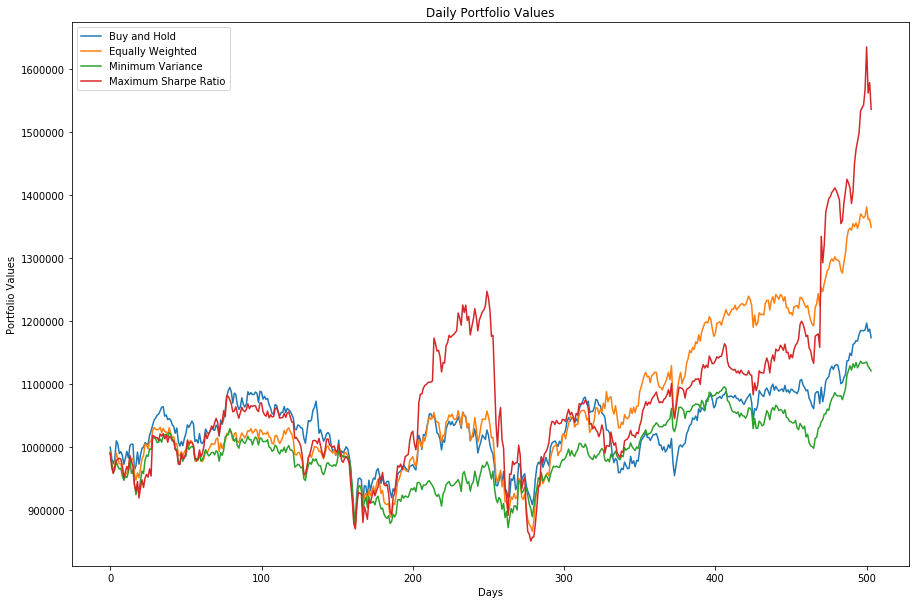

In [8]:
# PLOT DAILY PORTFOLIO VALUES
plt.figure(figsize=(15,10))
plt.plot(portf_value[0],label='Buy and Hold')
plt.plot(portf_value[1],label='Equally Weighted')
plt.plot(portf_value[2],label='Minimum Variance')
plt.plot(portf_value[3],label='Maximum Sharpe Ratio')
plt.legend()
plt.title('Daily Portfolio Values')
plt.xlabel('Days')
plt.ylabel('Portfolio Values')
plt.show()

### Plot Dynamic Changes in minVar Strategy

In [9]:
# GET NAMES FOR ALL ASSETS
col_names = df.columns[1:]

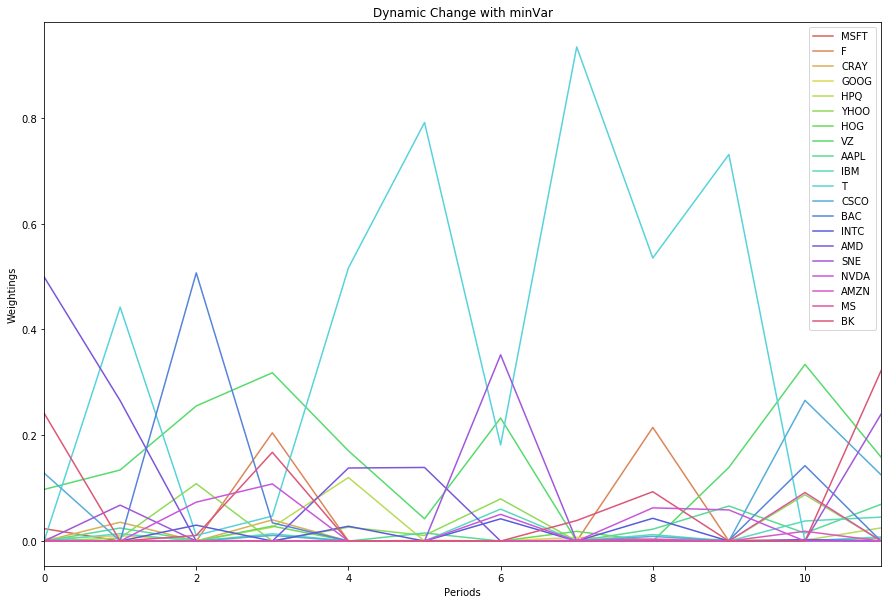

In [10]:
# PLOT DYNAMIC CHANGE FOR MIN VARIANCE
import seaborn as sns
sns.set_palette(sns.color_palette("hls", 20))
w_minvar = []
x[2, period-1], cash[2, period-1] = fh_array[2](curr_positions, curr_cash, mu, Q, cur_prices)
for period in range(1, N_periods+1):
    w_per_period = x[2, period-1]/sum(x[2, period-1])
    w_minvar.append(w_per_period)
df_minVar = pd.DataFrame(np.array(w_minvar),columns=col_names)
df_minVar.plot(figsize=(15,10))
plt.title('Dynamic Change with minVar')
plt.xlabel('Periods')
plt.ylabel('Weightings')
plt.show()

### Plot Dynamic Changes in maxSharpe Strategy

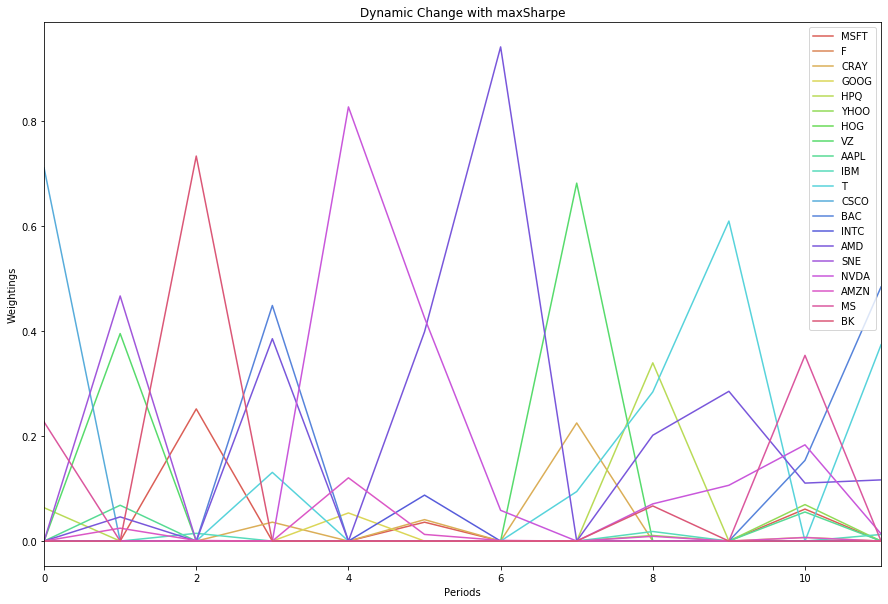

In [11]:
# PLOT DYNAMIC CHANGE FOR MAX SHARPE RATIO
import seaborn as sns
sns.set_palette(sns.color_palette("hls", 20))
w_maxsharpe = []
x[3, period-1], cash[3, period-1] = fh_array[3](curr_positions, curr_cash, mu, Q, cur_prices)
for period in range(1, N_periods+1):
    w_per_period = x[3, period-1]/sum(x[3, period-1])
    w_maxsharpe.append(w_per_period)
df_maxSharpe = pd.DataFrame(np.array(w_maxsharpe),columns=col_names)
df_maxSharpe.plot(figsize=(15,10))
plt.title('Dynamic Change with maxSharpe')
plt.xlabel('Periods')
plt.ylabel('Weightings')
plt.show()

### Strategy for Buy and Hold with equally weights at beginning

##### Calculate the Beginning Shares of each Asset (equally weighted)

In [30]:
portfolio_value = 1000002.12 #initial portfolio value almost one million dollars

cur_prices = data_prices[0,:] # the prices of each asset for the first day of periods

money_allocation = np.ones((20)) * portfolio_value / 20 # equally allocate money for each asset

x_optimal = np.floor(money_allocation / cur_prices) # Calculate the shares

x_optimal

array([ 1069.,  3255.,  1504.,    95.,  2736.,   996.,   759.,  1064.,
         457.,   308.,  1476.,  1810.,  2793.,  1375., 18726.,  2431.,
        2483.,   162.,  1291.,  1235.])

### Print Portfolio Values for the start and end of each period

In [13]:
# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()# prices for each asset
dates = np.array(df['Date'])

# Find the number of trading days in Nov-Dec 2014 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2014)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2014, start from 1/2/2015
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500, 0, 0, 0, 0, 0, 0, 1001, 0, 0, 0])

# Initial value of the portfolio, almost one million
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights, w=v*x/V
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year (2015,2016) 12
N = len(df.columns)-1#20
N_days = len(dates)#504 trading days

# Annual risk-free rate for years 2015-2016 is 2.5%
r_rf = 0.025

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_buy_and_hold_equally']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Minimum Variance Portfolio', 'Max Sharpe Ratio Portfolio', 'Buy and Hold Equally']
#N_strat = 1  
N_strat = len(strategy_functions)  # 5
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_buy_and_hold_equally]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)#4,12
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 15:
        cur_year  = 15 + math.floor(period/7)
    else:
        cur_year  = 2015 + math.floor(period/7)#progress to 2016
    
    
    cur_month = 2*((period-1)%6) + 1#1357911 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
    # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]

    # Execute portfolio selection strategies
    for strategy  in range(N_strat):

      # Get current portfolio positions
        if period == 1:
            curr_positions = init_positions
            curr_cash = 0
            portf_value[strategy] = np.zeros((N_days, 1))
        else:
            curr_positions = x[strategy, period-2]
            curr_cash = cash[strategy, period-2]
        
        # Compute strategy
        x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)
       
        # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
        # Check that cash account is >= 0
        # Check that we can buy new portfolio subject to transaction costs

        ###################### Insert your code here ############################
        
        if cash[strategy, period-1] < 0:
            
            portfolio_value = np.dot(cur_prices,curr_positions) + curr_cash
            ratio = np.array(x[strategy, period-1])/sum(x[strategy, period-1])
            minus_cash = abs(cash[strategy, period-1])*ratio
            minus_position = np.ceil(minus_cash/cur_prices)
            x[strategy, period-1] = x[strategy, period-1] - minus_position
            new_tran_cost = np.dot(cur_prices , abs(x[strategy, period-1]-curr_positions)) * 0.005
            cash[strategy, period-1] = portfolio_value - np.dot(cur_prices,x[strategy, period-1]) - new_tran_cost
        
        #########################################################################
        
        # Compute portfolio value
        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      
    # Compute expected returns and covariances for the next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
    mu = np.mean(cur_returns, axis = 0)
    Q = np.cov(cur_returns.T)


Initial portfolio value = $ 1000002.12


Period 1: start date 1/2/2015, end date 2/27/2015
  Strategy "Buy and Hold", value begin = $ 1000002.12, value end = $ 1043785.08
  Strategy "Equally Weighted Portfolio", value begin = $ 992880.88, value end = $ 1020038.79
  Strategy "Minimum Variance Portfolio", value begin = $ 991452.06, value end = $ 1016146.40
  Strategy "Max Sharpe Ratio Portfolio", value begin = $ 990052.34, value end = $ 1007863.43
  Strategy "Buy and Hold Equally", value begin = $ 992880.88, value end = $ 1020038.79

Period 2: start date 3/2/2015, end date 4/30/2015
  Strategy "Buy and Hold", value begin = $ 1045234.09, value end = $ 1069877.19
  Strategy "Equally Weighted Portfolio", value begin = $ 1030724.21, value end = $ 1011178.46
  Strategy "Minimum Variance Portfolio", value begin = $ 1023384.69, value end = $ 1014239.69
  Strategy "Max Sharpe Ratio Portfolio", value begin = $ 1017318.17, value end = $ 1056079.92
  Strategy "Buy and Hold Equally", value begin = 

### Interesting Observations in minVar Strategy

In [14]:
#AT&T variance at periods 5, 7 and 9
print('AT&T Period 5:',np.var(df[210:252]['T']))
print('AT&T Period 7:',np.var(df[295:333]['T']))
print('AT&T Period 9:',np.var(df[377:419]['T']))

#AMAZON variance at periods 5, 7 and 9
print('Amazon Period 5:',np.var(df[210:252]['AMZN']))
print('Amazon Period 7:',np.var(df[295:333]['AMZN']))
print('Amazon Period 9:',np.var(df[377:419]['AMZN']))

AT&T Period 5: 0.2871525804889754
AT&T Period 7: 1.5742341013035548
AT&T Period 9: 1.8367374682323425
Amazon Period 5: 1263.0540970888258
Amazon Period 7: 1620.6386205843241
Amazon Period 9: 246.21403116057485


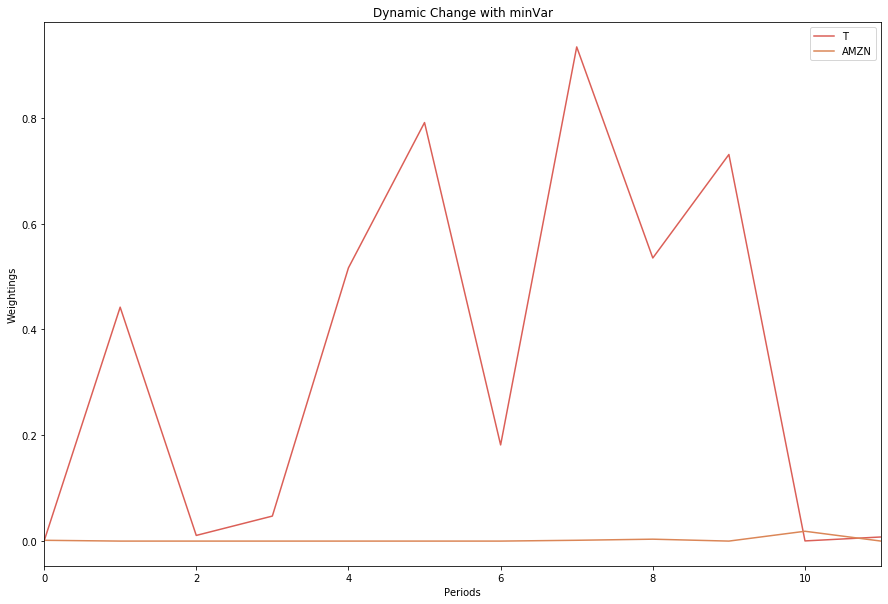

In [15]:
df_minVar.plot(y=['T','AMZN'],figsize=(15,10))
plt.title('Dynamic Change with minVar')
plt.xlabel('Periods')
plt.ylabel('Weightings')
plt.show()

### Interesting Observations in maxSharpe Strategy

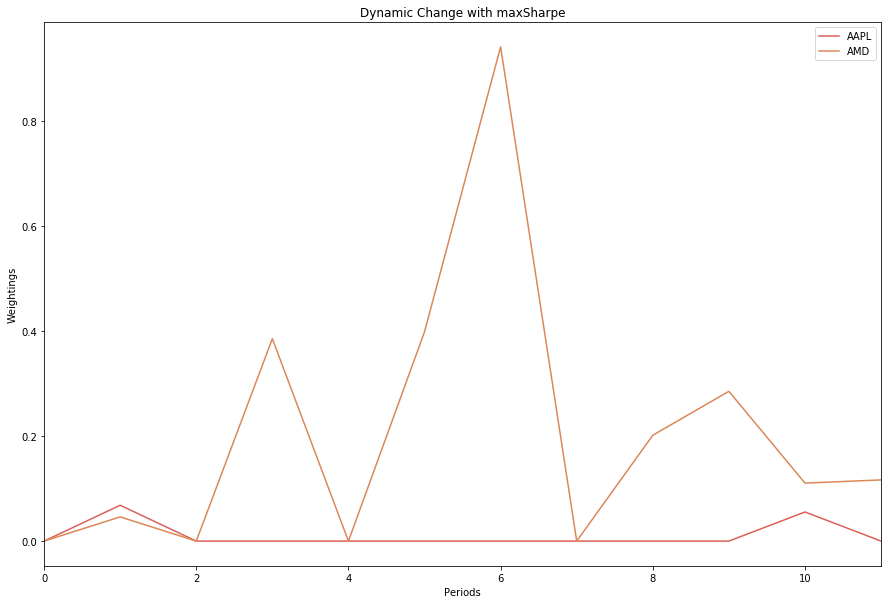

In [16]:
df_maxSharpe.plot(y=['AAPL','AMD'],figsize=(15,10))
plt.title('Dynamic Change with maxSharpe')
plt.xlabel('Periods')
plt.ylabel('Weightings')
plt.show()

In [17]:
#APPLE variance at periods 3, 6 and 9
print('AAPL Period 5: mean:',df[125:166]['AAPL'].mean(),'variance:',np.var(df[125:166]['AAPL']),'ratio:',df[125:166]['AAPL'].mean()/np.var(df[125:166]['AAPL']))
print('AAPL Period 7: mean:',df[253:294]['AAPL'].mean(),'variance:',np.var(df[253:294]['AAPL']),'ratio:',df[253:294]['AAPL'].mean()/np.var(df[253:294]['AAPL']))
print('AAPL Period 9: mean:',df[377:419]['AAPL'].mean(),'variance:',np.var(df[377:419]['AAPL']),'ratio:',df[377:419]['AAPL'].mean()/np.var(df[377:419]['AAPL']))

#AMD variance at periods 3, 6 and 9
print('AMD Period 5: mean:',df[125:166]['AMD'].mean(),'variance:',np.var(df[125:166]['AMD']),'ratio:',df[125:166]['AMD'].mean()/np.var(df[125:166]['AMD']))
print('AMD Period 7: mean:',df[253:294]['AMD'].mean(),'variance:',np.var(df[253:294]['AMD']),'ratio:',df[253:294]['AMD'].mean()/np.var(df[253:294]['AMD']))
print('AMD Period 9: mean:',df[377:419]['AMD'].mean(),'variance:',np.var(df[377:419]['AMD']),'ratio:',df[377:419]['AMD'].mean()/np.var(df[377:419]['AMD']))

AAPL Period 5: mean: 128.19341421951216 variance: 3.9789204928734776 ratio: 32.21813917848207
AAPL Period 7: mean: 114.21560948780488 variance: 24.332909745846294 ratio: 4.693873880303274
AAPL Period 9: mean: 95.88642842857142 variance: 7.096736059121009 ratio: 13.511342063417215
AMD Period 5: mean: 2.3607317073170733 variance: 0.011455562165377759 ratio: 206.07733372107504
AMD Period 7: mean: 2.3846341463414635 variance: 0.08566876859012493 ratio: 27.835513286651132
AMD Period 9: mean: 4.364523809523808 variance: 0.29932001133786834 ratio: 14.581463464523237
